In [1]:
import sys
sys.path.append("/Users/haas/Documents/Masters/GANQS/src/")
from nqs import anqs, pretrain
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

### System

In [2]:
nparticles = 2
dim = 2
seed = 42
mcmc_alg = "m" 
training_cycles = 100 
batch_size = 10000


### Generator


In [3]:
gen_system = anqs.GNQS(
    nqs_repr="psi",
    backend="jax",
    log=True,
    logger_level="INFO",
    seed=seed,
)

gen_system.set_wf(
    "ffnn",
    nparticles,
    dim,  # all after this is kwargs.
    layer_sizes=[
        nparticles * dim,  # should always be this
        7,
        5,
        3,
        1,  # should always be this
    ],
    activations=["gelu", "gelu", "gelu", "linear"],
    symmetry="none",
)

gen_system.set_sampler(mcmc_alg=mcmc_alg, scale=1)
gen_system.set_hamiltonian(
    type_="ho", int_type="Coulomb", omega=1.0, r0_reg=1, training_cycles=training_cycles
)

INFO:GNQS     Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.


In [4]:
### generate untrained sample
state = gen_system.wf.state
states = state.create_batch_of_states(batch_size=batch_size)
sample = gen_system._sampler.step(
    gen_system.wf, states, seed, batch_size=batch_size
)

sample.positions.shape

(10000, 4)

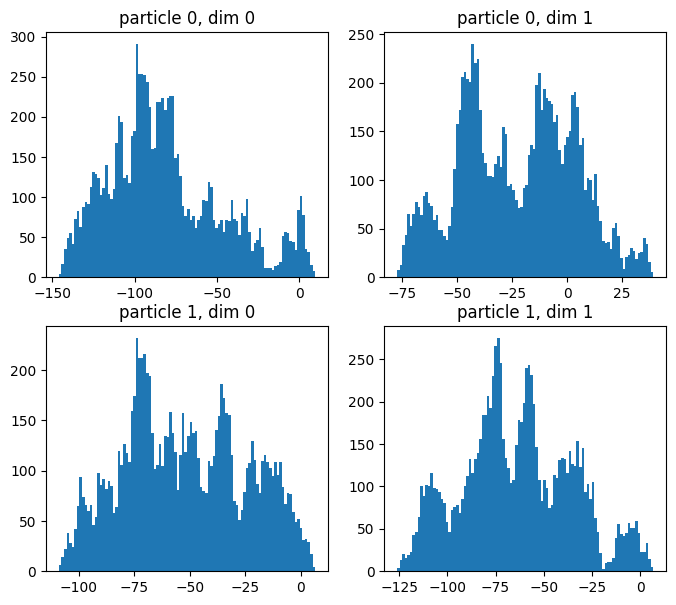

In [5]:

fig, ax = plt.subplots(nparticles, dim, figsize=(8, 7))
for i in range(nparticles):
    for j in range(dim):
        ax[i, j].hist(sample.positions[:, i*dim + j], bins=100)
        ax[i, j].set_title(f"particle {i}, dim {j}")

### Truth

In [6]:

truth = np.random.normal(size=(batch_size, nparticles*dim));
truth.shape

(10000, 4)

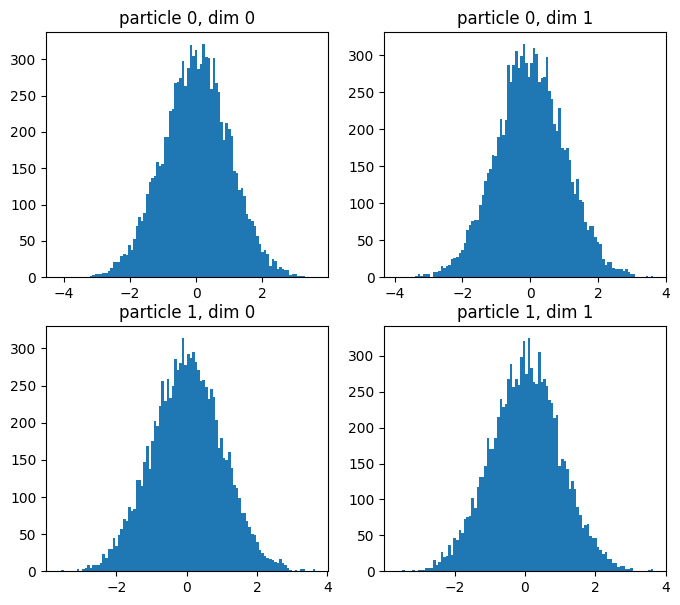

In [7]:
#plot histogram of the truth in each dimension for each particle

fig, axs = plt.subplots(nparticles, dim, figsize=(8, 7))
for i in range(nparticles):
    for j in range(dim):
        axs[i, j].hist(truth[:, i*dim + j], bins=100)
        axs[i, j].set_title(f"particle {i}, dim {j}")


### Discriminator

In [8]:
disc_system = anqs.DNQS(
    backend="jax",
    log=True,
    logger_level="INFO",
    seed=seed,
)

disc_system.set_net(
    "ffnn",
    nparticles,
    dim,  # all after this is kwargs.
    layer_sizes=[
        nparticles * dim,  # should always be this
        7,
        5,
        3,
        1,  # should always be this
    ],
    activations=["relu", "relu", "relu", "sigmoid"],
)

disc_system.set_optimizer("adam", eta=0.01)

INFO:DNQS     Neural Network Quantum State initialized with symmetry None as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 7 neurons
Hidden Layer (Layer 2): 5 neurons
Hidden Layer (Layer 3): 3 neurons
Output Layer (Layer 4): 1 neurons
------------------------------.


In [9]:
# generate train data (concatenate training and generated samples with a flag)
train_data = jnp.concatenate((truth, sample.positions), axis=0)
train_labels = jnp.concatenate((jnp.ones(batch_size), jnp.zeros(batch_size))) # 1 for truth, 0 for generated

#shuffle data
idx = np.arange(2*batch_size)
np.random.shuffle(idx)
train_data = train_data[idx]
train_labels = train_labels[idx]


## Part1: Can disc learn alone to differentiate horrible samples from a gaussian?

INFO:DNQS     Discriminator Training done


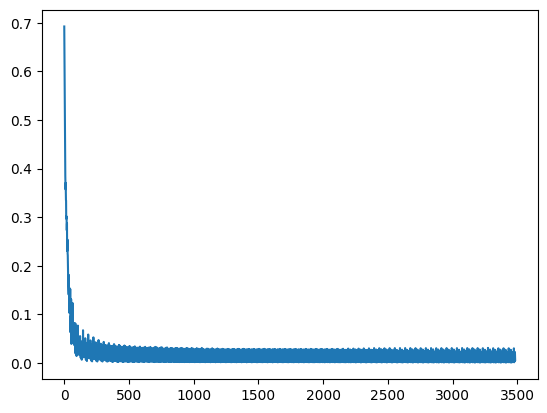

In [10]:
epochs = 100
training_batch_size = 500 # will divide train data in batches of this size

history = disc_system.train(train_data, train_labels, epochs, training_batch_size)
plt.plot(history)

### It seems to work. Next step is to see if after training, the discriminator still is capable of seeing the diffs
#### If the discriminator is still able to, then we can go to the next step: compute a loss that involves both gen and disc

## Part 2: train the (non interacting) generator and without symmetry.

### then plot some samples to see if the disc still can see the diff

INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 5 neurons
Hidden Layer (Layer 2): 3 neurons
Output Layer (Layer 3): 1 neurons
------------------------------.
INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 5 neurons
Hidden Layer (Layer 2): 3 neurons
Output Layer (Layer 3): 1 neurons
------------------------------.
INFO:NQS      Neural Network Quantum State initialized with symmetry none as FFNN with Neural Network Architecture
------------------------------
Input Layer (Layer 0): 4 neurons
Hidden Layer (Layer 1): 5 neurons
Hidden Layer (Layer 2): 3 neurons
Output Layer (Layer 3): 1 neurons
------------------------------.
INFO:NQS      Neural Network Quantum State initialized with s

[Training progress]:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:NQS      Training done
INFO:NQS      Training done
INFO:NQS      Training done
INFO:NQS      Training done
INFO:NQS      Training done
INFO:NQS      Training done


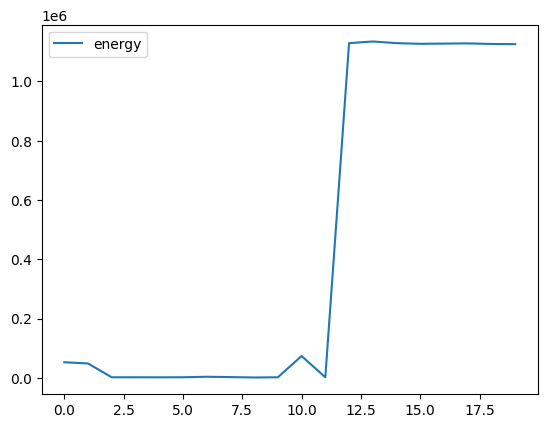

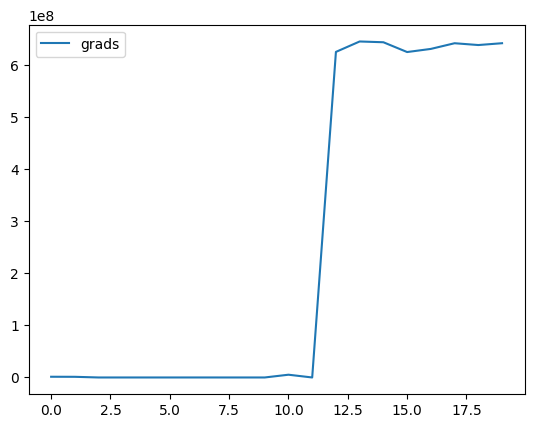

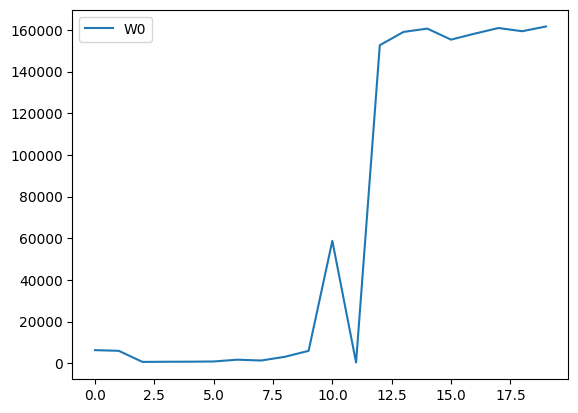

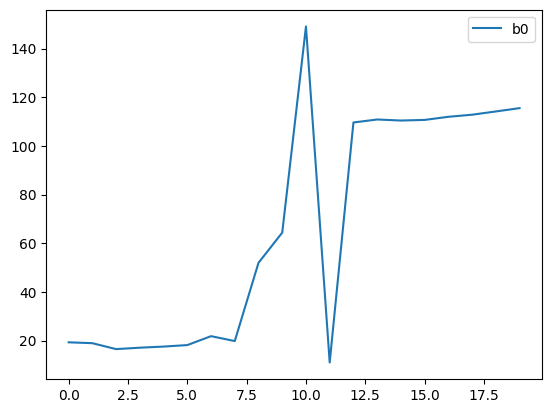

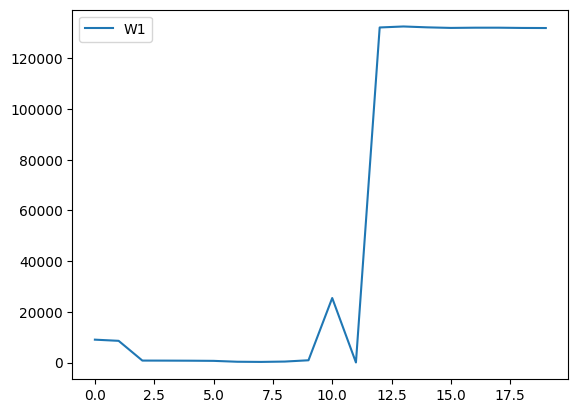

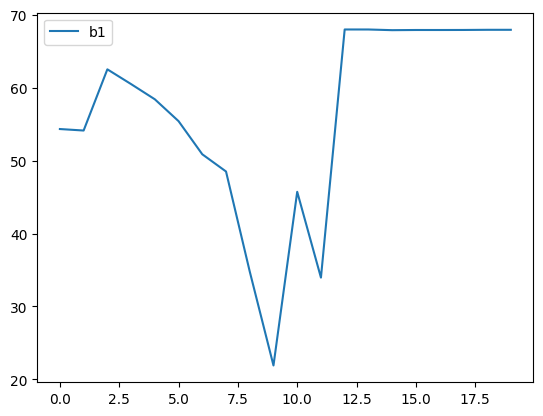

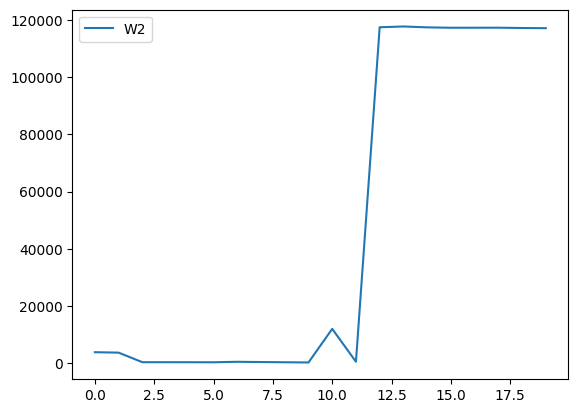

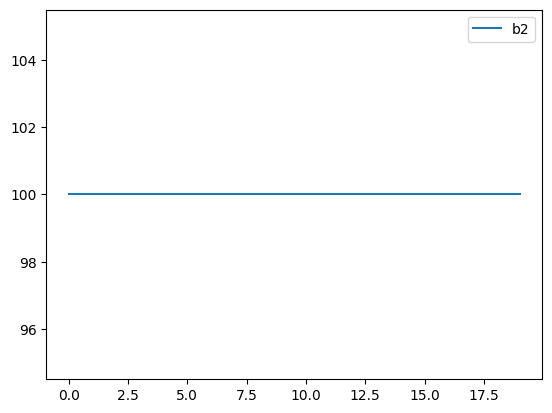

In [ ]:

#gen_system.pretrain(model="Gaussian", max_iter=1000, batch_size=1000)


history = gen_system.train(
    max_iter=20,
    batch_size=batch_size,
    early_stop=False,
    seed=seed,
    history=True,
    tune=False,
    grad_clip=0,
)

epochs = np.arange(len(history["energy"]))
for key, value in history.items():
    plt.plot(epochs, value, label=key)
    plt.legend()
    plt.show()

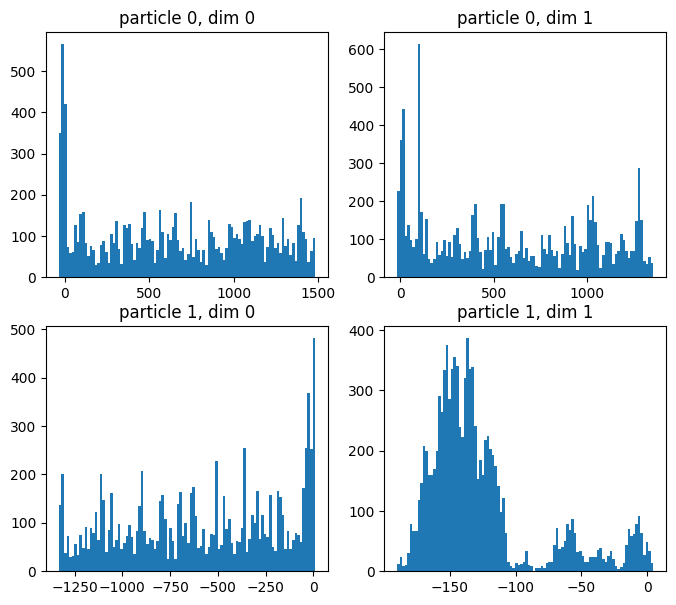

In [ ]:

### generate "trained" sample
state = gen_system.wf.state
states = state.create_batch_of_states(batch_size=batch_size)
sample = gen_system._sampler.step(
    gen_system.wf, states, seed, batch_size=batch_size
)


fig, ax = plt.subplots(nparticles, dim, figsize=(8, 7))
for i in range(nparticles):
    for j in range(dim):
        ax[i, j].hist(sample.positions[:, i*dim + j], bins=100)
        ax[i, j].set_title(f"particle {i}, dim {j}")